# Modelling of Text Summarization

Code adpated from 
https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

## Import Modules

In [46]:
# Import modules and packages
import nltk
import string
import numpy as np  
import pandas as pd 
import re           
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import os

In [44]:
!python attention_ut.py

2022-03-08 23:15:33.068264: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-03-08 23:15:33.068298: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [47]:
from attention_ut import AttentionLayer  

In [33]:
#nltk.download()
#print(nltk.__version__)
#dir(nltk)
#!pip install attention

## Load Cleaned Data

In [49]:
# Load master table
df = pd.read_csv("master.csv")

# Review sentences and summary
for i in range(5):
    print("Text:",df['cleaned_text'][i])
    print("Summary:",df['summary'][i])
    print("\n")

Text: 234 particulars lot location tai po road tai po kau tai po new territories site delineated shown coloured pink pink hatched black pink hatched black stippled black pink stippled black plan annexed hereto area square metres 14 002 rent annual rent amount equal 3 rateable value time time lot subject general condition
Summary: _START_ location tai po road tai po kau tai po new territories site area 14 002 square metres  _END_


Text: c purchaser shall expense uphold manage maintain repair existing buildings structures lifetime thereof respects satisfaction director
Summary: _START_ to maintain and repair existing buildings _END_


Text: event purchaser decides demolish remove existing buildings structures part parts thereof purchaser shall bear costs expenses arising connection said demolition removal shall carry demolition removal existing buildings structures respects satisfaction director
Summary: _START_ demolish and remove existing buildings _END_


Text: 3 purchaser acknowledg

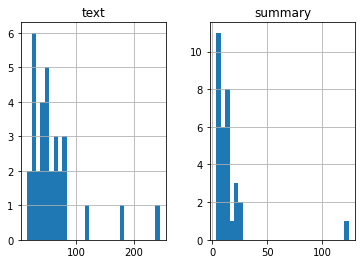

In [50]:
# Plot word count lengths of sentences

import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [51]:
# Set maximum text and summary lengths for the padding
max_len_text = length_df.text.max()
max_len_summary = length_df.summary.max()

The maximum text length is long after splitting because some data contained multiple points, and the bullet notations were retained in the cleaning step.

In [52]:
# Train test split
from sklearn.model_selection import train_test_split
x_train, x_test , y_train, y_test = train_test_split(df['cleaned_text'], df['summary'], 
                                                     test_size=0.2, random_state=37, shuffle=True) 

## Prepare Tokenizer

### Text Tokenizer

In [53]:
# Prepare a tokenizer for text on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences
x_train = x_tokenizer.texts_to_sequences(x_train) 
x_test = x_tokenizer.texts_to_sequences(x_test)

#padding zero upto maximum length
x_train = pad_sequences(x_train,  maxlen=max_len_text, padding='post') 
x_test = pad_sequences(x_test, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) +1

### Summary Tokenizer 

In [54]:
# Prepare a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

#convert summary sequences into integer sequences
y_train = y_tokenizer.texts_to_sequences(y_train) 
y_test = y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train = pad_sequences(y_train, maxlen=max_len_summary, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) +1

## Modelling

In [55]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])    

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 244, 500)     241500      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 244, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [57]:
# Specify loss function
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Specify early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# Specify batch size
history = model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                    epochs=25, callbacks=[es], batch_size=128, validation_data=([x_test,y_test[:,:-1]], 
                                                                                y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/50
1/1 [==============================] - 46s 46s/step - loss: 4.9766 - val_loss: 2.2531
Epoch 2/50
1/1 [==============================] - 32s 32s/step - loss: 2.4675 - val_loss: 0.5671
Epoch 3/50
1/1 [==============================] - 35s 35s/step - loss: 1.4584 - val_loss: 0.7546
Epoch 00003: early stopping


### Diagnostic plot

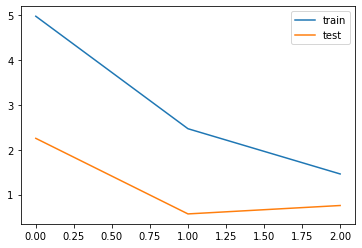

In [59]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [60]:
# Build dictionary to convert index to word for target and source vocabulary
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

### Inference

Set up the inference for the encoder and decoder:

In [62]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, 
                                                    initial_state=[decoder_state_input_h, 
                                                                   decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [74]:
# Define function to implement inference process 
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [75]:
# Define functions to convert an integer sequence to a word sequence for summary and text
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString = newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
      if(i!=0):
        newString = newString+reverse_source_word_index[i]+' '
    return newString

In [76]:
for i in range(len(x_test)):
  print("Text:", seq2text(x_test[i]))
  print("Original summary:", seq2summary(y_test[i]))
  print("Predicted summary:", decode_sequence(x_test[i].reshape(1, max_len_text)))
  print("\n")

Text: 7 hereof lot thereof building buildings erected erected lot shall respects buildings ordinance compliance ordinance gross floor area design building design building b c building buildings may erected lot part thereof area areas outside lot conditions may development use lot part thereof area areas outside lot conditions respects ordinance regulations made thereunder amending legislation gross floor area building buildings erected erected lot shall less 8 square metres shall square metres design building buildings erected erected lot shall approval writing director building works works existing buildings structures accordance special condition 
Original summary: area square metres 


KeyError: 0

In [83]:
for i in range(len(x_test)):
  print("Text:", seq2text(x_test[i]))
  print("Original summary:", seq2summary(y_test[i]))
  print("\n")

Text: 7 hereof lot thereof building buildings erected erected lot shall respects buildings ordinance compliance ordinance gross floor area design building design building b c building buildings may erected lot part thereof area areas outside lot conditions may development use lot part thereof area areas outside lot conditions respects ordinance regulations made thereunder amending legislation gross floor area building buildings erected erected lot shall less 8 square metres shall square metres design building buildings erected erected lot shall approval writing director building works works existing buildings structures accordance special condition 
Original summary: area square metres 


Text: purchaser shall 30111 day september 2028 date may approved director purchaser expense manner materials standards levels alignment design director shall approve respects satisfaction director lay form future public road shown coloured green plan annexed hereto hereinafter referred green area ii p

In [84]:
for i in range(len(x_test)):
    print(decode_sequence(x_test[i].reshape(1, max_len_text)))

KeyError: 0